# Automatic Forecasting with TempEst-NEXT

This Notebook automatically generates forecasts out to 17 days for a specified watershed.  It will eventually include three approaches:

1. Pour point forecast: one watershed.
2. Nested forecast: the whole upstream system at kilometer resolution, run as tightly-nested lumped models.
3. Interpolated forecast: the whole upstream system, using kilometer-scale smart interpolation or a reach model between confluences.

For convenience, it is assumed that the downstream point is a USGS gage.  However, NEXT's automatic data retrieval tools can work with coordinates as well, with no gage required.

We will set up the watershed model based on 5 years of daymet data (2018-2022), then run the next 17 days with GFS data.

Note that this code can be readily modified for hindcasting, using either estimated or reforecasted weather, by just running the model for `ws_data` (possibly with a different time period) instead of `fcst_input`.  `ws_data` by default is daymet estimated weather.  This can be changed to HRRR archives (using `weather='hrrr'`) to evaluate short-term forecasting performance.  The GFS data source only goes back about a week, so that cannot be used for historical runs, but HRRR goes back to 2014.

# Setup and Watershed Identification

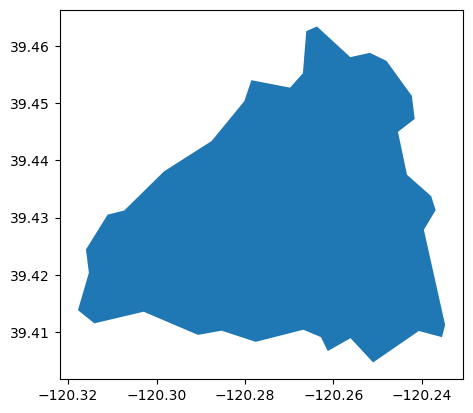

In [157]:
import NEXT
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import datetime
import dataretrieval.nwis as nwis
from pynhd import NLDI
from time import time
# USGS gage as downstream location
site = "10343500"    # Sagehen Creek nr Truckee, CA.  Small mountain watershed in Eastern Sierra.
# site = "01646500"    # Potomac R near Little Falls Pump Stn., DC.  Large river near AGU24.  Possibly skewed by discharges.
# site = "01638500"    # Potomac R. at Point of Rocks, MD.  A little upstream to avoid the alteration.
NEXT.data.gage_geom(site)[0].plot()
model = NEXT.NEXT.from_pickle("coefs.pickle")  # prepare a coefficient estimation model
nldi = NLDI()

# Shared Functions

These functions will be used by all forecast techniques.

In [115]:
def fix_sitename(site):
    # Coordinate-type site format is lon:lat, which doesn't work as a file name.
    return site.replace(":", "_")

def get_site_type(site):
    if ":" in site:
        return "coordinates"
    else:
        return "usgs"

In [116]:
def prepare_model(site):
    dpath = f"site_cache/prep_data_{fix_sitename(site)}.csv"
    if os.path.exists(dpath):
        ws_data = pd.read_csv(dpath, dtype={"id": "str"}, parse_dates=["date"])
    else:
        ws_data = NEXT.data.full_data(site, "2018-01-01", "2022-12-31", site_type=get_site_type(site), weather="daymet")
        ws_data.to_csv(dpath, index=False)
    return model.make_newt(ws_data, use_climate=False, reset=True).get_newt()  # for a 5-year period of record, we don't need the climate engine.

In [139]:
# Data Prep.  We also want to get the last week or so as inputs to the anomaly function.
def forecast_inputs(site):
    earlier = (datetime.date.today() - datetime.timedelta(6)).strftime("%Y-%m-%d")
    today = datetime.date.today().strftime("%Y-%m-%d")
    fcst_path = f"site_cache/inp_forecast_{fix_sitename(site)}_{today}.csv"
    end = (datetime.date.today() + datetime.timedelta(16)).strftime("%Y-%m-%d")
    if os.path.exists(fcst_path):
        fcst_input = pd.read_csv(fcst_path, dtype={"id": "str"}, parse_dates=["date"])
    else:
        recent = NEXT.data.full_data(site, earlier, today, weather="gfs", site_type=get_site_type(site))
        recent = recent[recent["date"] < pd.to_datetime(today)]
        fcst_input = pd.concat([recent, NEXT.data.full_data(site, today, end, weather="gfs", site_type=get_site_type(site))])
        fcst_input.index = range(len(fcst_input))
        fcst_input.to_csv(fcst_path, index=False)
    return fcst_input

In [147]:
# Run the forecast
# The last day isn't actually used, so we'll add a blank row.  Only do this one.
def run_forecast(fcst_input, newt, site):
    today = datetime.date.today().strftime("%Y-%m-%d")
    fcst_input = pd.concat([fcst_input, pd.DataFrame(fcst_input.iloc[22]).T]) if len(fcst_input) == 23 else fcst_input
    fcst_input.index = range(len(fcst_input))
    fcst_input.loc[23, "date"] = fcst_input["date"].iloc[-2] + np.timedelta64(1, 'D')
    fcst_input["date"] = pd.to_datetime(fcst_input["date"])
    forecast = newt.run_series(fcst_input)[["id", "lat", "lon", "date", "actemp", "anom", "temp.mod"]]
    forecast.to_csv(f"site_cache/forecast_{fix_sitename(site)}_{today}.csv", index=False)
    return forecast

# Pour Point Forecast

We are assuming the pour point is a USGS gage (which is not necessary).  If it has stream temperature, we can come back later and check our forecasts.

## Forecast

### Model Preparation

In [ ]:
newt = prepare_model(site)

### Actual Forecast

In [ ]:
fcst_input = forecast_inputs(site)
fcst_input

In [ ]:
forecast = run_forecast(fcst_input, newt)
forecast

<Axes: xlabel='date'>

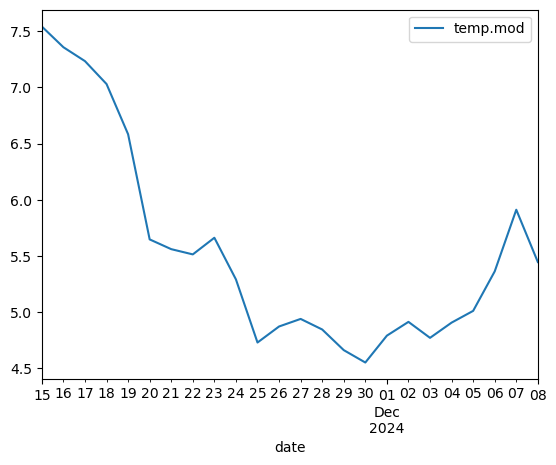

In [29]:
# Plot the forecast
forecast.plot(x="date", y="temp.mod", layout="compressed")

## Validation

To validate a forecast, specify the date it was run on.  The notebook will retrieve river temperature observations and evaluate performance.

# Tightly Nested Watersheds

One approach to high-resolution modeling is to simply run a full, lumped watershed for each kilometer of river.  This is rather inefficient, since it involves a lot of redundant data retrieval, but it is straightforward because it can be run with only a lumped model.  It also serves to test the stability of model predictions in space.  The bulk of the analysis here is creating subwatersheds; after that, we simply run lumped models as per usual.

Since this isn't a good standard approach to high-resolution modeling, the watershed splicing is not built in to NEXT.

Kilometer spacing is not exact, since NHD+ spacing varies, but it is guaranteed to be less than 0.015 degrees, which is about 1.5 km in latitude and less (latitude-dependent) in longitude.

## Set Up Coordinates

In [108]:
(ws, lat, lon, area) = NEXT.data.gage_geom(site)
coords = (lon, lat)

In [127]:
def recurse_upstream(coords, old_comid="none"):
    # Recursively build the upstream flow network at km resolution.
    # First, get the upstream geometry.  Each linestring is a reach or a tributary.
    mains = nldi.navigate_byloc(coords, "upstreamMain", source="flowlines", distance=1)
    if len(mains) == 1 and mains["nhdplus_comid"].iloc[0] == old_comid:
        return []  # We have hit the top
    tribs = nldi.navigate_byloc(coords, "upstreamTributaries", source="flowlines", distance=1)
    # UpstreamTributaries includes mainstem.  Get just the non-mainstem ones.
    tribs = tribs[-tribs["nhdplus_comid"].isin(mains["nhdplus_comid"])]
    # Uppermost coordinate of mainstem (i.e. ~1 km up).
    main_upper =  mains.iloc[-1].geometry
    if main_upper.length < 0.015:
        main_top = main_upper.coords[0]
    else:
        main_top = main_upper.interpolate(0.01).coords[0]
    main_comid = mains["nhdplus_comid"].iloc[-1]
    # We need to use tributary COMIDs to get their tops, since their bottom points are on the mainstem.
    trib_comids = tribs["nhdplus_comid"]
    # Now we have a full list, and we can go ahead and iterate upstream.
    result = [main_top] + recurse_upstream(main_top, main_comid)
    for comid in trib_comids:
        tupper = nldi.navigate_byid("comid", comid, "upstreamMain", source="flowlines", distance=1).iloc[-1].geometry
        if tupper.length < 0.015:
            ttop = tupper.coords[0]
        else:
            ttop = tupper.interpolate(0.01).coords[0]
        result.append(ttop)
        result += recurse_upstream(ttop, comid)
    return result

In [134]:
clist = [coords] + recurse_upstream(coords)
len(clist)

11

In [132]:
cf = pd.DataFrame(clist, columns=["lon", "lat"])

<Axes: xlabel='lon', ylabel='lat'>

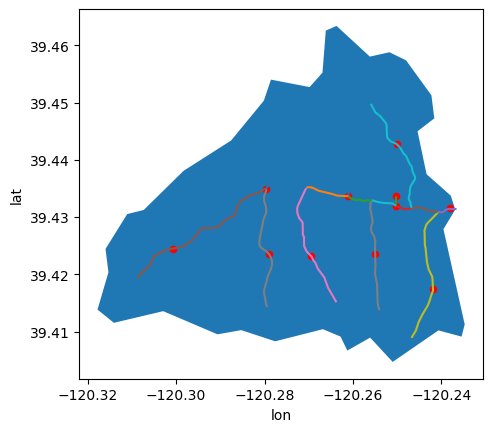

In [133]:
ax = ws.plot()
cf.plot.scatter(x="lon", y="lat", ax=ax, c="red")
nldi.navigate_byloc(coords, "upstreamTributaries", source="flowlines", distance=100).plot("nhdplus_comid", ax=ax)

## Prepare Forecasts

While we're at it, let's see how long this takes.

- Sagehen (11 points):
    - With full data retrieval: 37 minutes (3.5/ws)
    - With forecast retrieval only: 
    - Without (modeling only): 0.03 minutes (<1 second/ws)


In [148]:
start = time()
forecast_list = [
    run_forecast(
        forecast_inputs(f"{x}:{y}"),
        prepare_model(f"{x}:{y}"),
        f"{x}:{y}"
    )
    for (x, y) in clist
]
forecast = pd.concat(forecast_list)
runtime = (time() - start) / 60
print(f"Took {runtime:.2f} minutes")

Took 0.02 minutes


## Plot Forecasts

In Sagehen, the entire watershed is probably one GFS cell, so the forecast trends are nearly identical in shape (though differing in magnitude).

We can also animate it.

<Axes: xlabel='date', ylabel='temp.mod'>

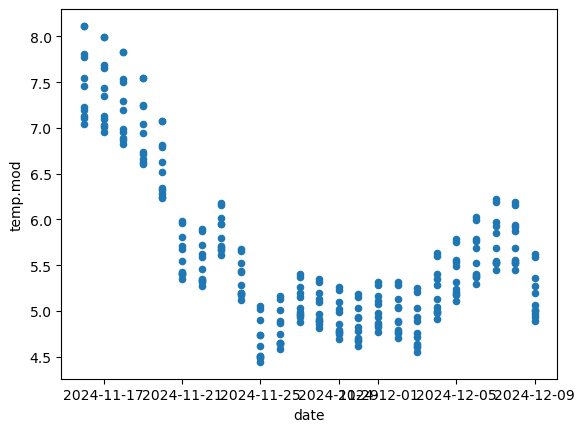

In [155]:
forecast.plot.scatter(x="date", y="temp.mod")

MovieWriter ffmpeg unavailable; using Pillow instead.


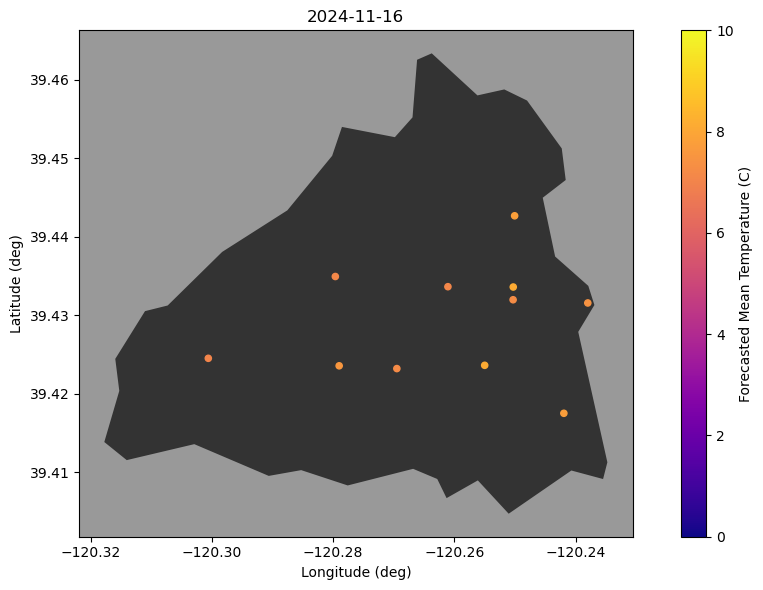

In [159]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(facecolor="#999")
dates = np.array(forecast["date"].unique(), dtype='datetime64[D]')
def animate(i):
    date = dates[i]
    fig.clear()
    ax = plt.axes(facecolor="#999")
    ws.plot(ax=ax, color="#333")
    forecast[forecast["date"] == date].plot.scatter(x="lon", y="lat", c="temp.mod", title=str(date), ax=ax, colormap="plasma", vmin=0, vmax=5 * (forecast["temp.mod"].max() // 5 + 1))
    ax.collections[1].colorbar.set_label("Forecasted Mean Temperature (C)")
    ax.set_xlabel("Longitude (deg)")
    ax.set_ylabel("Latitude (deg)")
    plt.tight_layout()

a = anim.FuncAnimation(fig, animate, interval=1000, frames=range(len(dates)))
a.save(f"forecast_anims/{site}_forecast.gif")